In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month

from statsmodels.compat.pandas import Appender

import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.estimators.yule_walker import yule_walker
from statsmodels.tsa.arima.estimators.burg import burg
from statsmodels.tsa.arima.estimators.hannan_rissanen import hannan_rissanen
from statsmodels.tsa.arima.estimators.innovations import (
    innovations, innovations_mle)
from statsmodels.tsa.arima.estimators.gls import gls as estimate_gls

from statsmodels.tsa.arima.specification import SARIMAXSpecification
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

import itertools

from pmdarima.utils import diff_inv

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Load diffed and undiffed electrical consumption data</h4>

In [110]:
# load undiffed consumption data from EDA notebook (not diffed)
cov_rem = pd.read_csv('stationary-data/cov_rem.csv').set_index('Date')

In [111]:
cov_rem_arr = np.asarray(cov_rem)

#### Train model using full dataset

In [145]:
# Create a dataframe with index length of my prediction 
cov_rem.index = pd.to_datetime(cov_rem.index, infer_datetime_format=True)
index = pd.date_range(start='2020-02-28', end='2035-01-31', freq='M')
columns = ['avg_kwh_capita']
future_kwh = pd.DataFrame(index=index, columns=columns)

# Merge empty rediction df with the observed values df for endogenous factors in my model
future_kwh = future_kwh.merge(cov_rem, on='avg_kwh_capita', how='outer', left_index=True, right_index=True)

# Train a SARIMAX model with observed values 
e_consum_model = sm.tsa.statespace.SARIMAX(future_kwh, order=(0, 1, 2), seasonal_order=(2, 2, 1, 12)).fit()

# generate predictions from the start of observed data to city goal period 
preds = e_consum_model.get_prediction(start='2012-01-31', end='2035-01-31')

#(0, 1, 2)(2, 2, 1, 12)627.256549


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### Generate df for plotting forecast in Dash

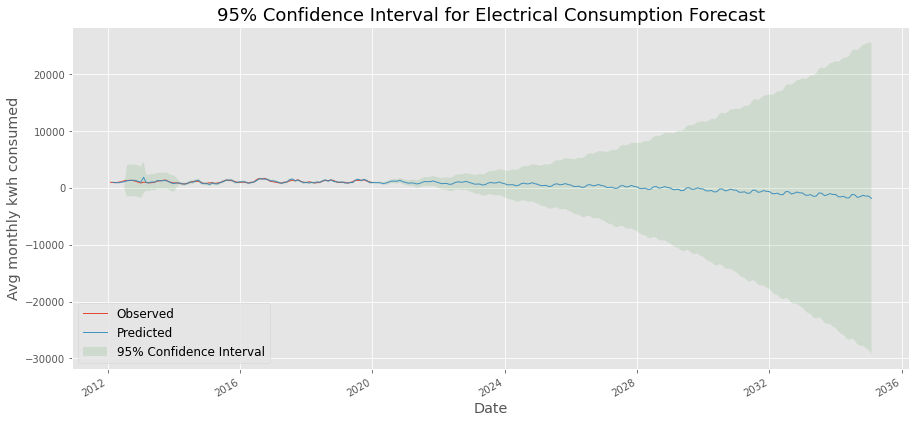

<Figure size 432x288 with 0 Axes>

In [156]:
# Generate plot of observed and predicted values with a 95% confidence interval

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2012-02-28', end='2035-01-31')
pred_ci = preds.conf_int()

# replace lower bound large confidence interval values with 0 to better visualize
pred_ci['lower avg_kwh_capita'][0] = 0
pred_ci['lower avg_kwh_capita'][1] = 0
pred_ci['lower avg_kwh_capita'][2] = 0
pred_ci['lower avg_kwh_capita'][3] = 0
pred_ci['lower avg_kwh_capita'][4] = 0

# replace upper bound large confidence interval values with 0 to better visualize
pred_ci['upper avg_kwh_capita'][0] = 0
pred_ci['upper avg_kwh_capita'][1] = 0
pred_ci['upper avg_kwh_capita'][2] = 0
pred_ci['upper avg_kwh_capita'][3] = 0
pred_ci['upper avg_kwh_capita'][4] = 0

ax = future_kwh['2012-01-31':].plot(label='observed', linewidth=1.0)
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(15, 7), linewidth=1.0,)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("95% Confidence Interval for Electrical Consumption Forecast", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.show()
plt.draw()
# fig1.savefig('images/zoom_out_ci_diffed.png', dpi=100)

In [178]:
# convert SARIMA prediction to df
undiffed_preds_full = preds.predicted_mean
undiffed_preds_full = undiffed_preds_full.to_frame()
undiffed_preds_full.head()

# add ci columns to prediction df
undiffed_preds_full['lower_ci'] = pred_ci['lower avg_kwh_capita']
undiffed_preds_full['upper_ci'] = pred_ci['upper avg_kwh_capita']

#### Create phase reduction df

In [148]:
# calculate reduction in overall average kwh 
# from 100% reduction of 2153 addresses within 6 month phase 
# 100313 total addresses accounted for in avg kwh calc 
# what percent is 2153 of 100313? (2153/100313)*100 = 2.146282136911467 (%reduction / phase) 
# find average kwh for each phase and cumulatiively subtract 2.14...% 
# of phase avg from overall avg

phase_reductions = pd.DataFrame(columns=['phase','phase_avg'])

In [149]:
# from predictions using lat long
phase_reductions['phase'] = [1,2,3,4]
phase_reductions['phase_avg'] = [3212.1891155807666,
                                 3302.7971164640726,
                                 3182.907276495421,
                                 4011.506785622089]
phase_reductions.head()

,phase,phase_avg
0,1,3212.189116
1,2,3302.797116
2,3,3182.907276
3,4,4011.506786


In [150]:
# generate reduction values for each phase proportionate to # buildings out of total in city
phase_reductions['max_reduction_amount'] = phase_reductions['phase_avg']* .02146282136911467

In [151]:
phase_reductions

,phase,phase_avg,max_reduction_amount
0,1,3212.189116,68.942641
1,2,3302.797116,70.887345
2,3,3182.907276,68.314170
3,4,4011.506786,86.098254


#### Add data for efficiency improvements split equally in 4 phases

In [179]:
# generate reduction values for each phase
undiffed_preds_full['phase_1'] = undiffed_preds_full['predicted_mean']
undiffed_preds_full['phase_2'] = undiffed_preds_full['phase_1']
undiffed_preds_full['phase_3'] = undiffed_preds_full['phase_2']
undiffed_preds_full['phase_4'] = undiffed_preds_full['phase_3']

In [180]:
# add lower and upper ci columns for each phase

# lower ci for each phase
undiffed_preds_full['phase_0_lower'] = undiffed_preds_full['lower_ci']
undiffed_preds_full['phase_1_lower'] = undiffed_preds_full['lower_ci']
undiffed_preds_full['phase_2_lower'] = undiffed_preds_full['lower_ci']
undiffed_preds_full['phase_3_lower'] = undiffed_preds_full['lower_ci']
undiffed_preds_full['phase_4_lower'] = undiffed_preds_full['lower_ci']

# upper ci for each phase
undiffed_preds_full['phase_0_upper'] = undiffed_preds_full['upper_ci']
undiffed_preds_full['phase_1_upper'] = undiffed_preds_full['upper_ci']
undiffed_preds_full['phase_2_upper'] = undiffed_preds_full['upper_ci']
undiffed_preds_full['phase_3_upper'] = undiffed_preds_full['upper_ci']
undiffed_preds_full['phase_4_upper'] = undiffed_preds_full['upper_ci']

In [181]:
# create columns for each phase's reduction amount 
undiffed_preds_full['phase_1_impr'] = 68.942641
undiffed_preds_full['phase_2_impr'] = 70.887345
undiffed_preds_full['phase_3_impr'] = 68.314170
undiffed_preds_full['phase_4_impr'] = 86.098254

In [183]:
undiffed_preds_full.head()

,predicted_mean,lower_ci,upper_ci,phase_1,phase_2,phase_3,phase_4,phase_0_lower,phase_1_lower,phase_2_lower,phase_3_lower,phase_4_lower,phase_0_upper,phase_1_upper,phase_2_upper,phase_3_upper,phase_4_upper,phase_1_impr,phase_2_impr,phase_3_impr,phase_4_impr
2012-02-28,997.894033,0.0,0.0,997.894033,997.894033,997.894033,997.894033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.942641,70.887345,68.31417,86.098254
2012-03-31,956.404922,0.0,0.0,956.404922,956.404922,956.404922,956.404922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.942641,70.887345,68.31417,86.098254
2012-04-30,907.262704,0.0,0.0,907.262704,907.262704,907.262704,907.262704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.942641,70.887345,68.31417,86.098254
2012-05-31,1023.516529,0.0,0.0,1023.516529,1023.516529,1023.516529,1023.516529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.942641,70.887345,68.31417,86.098254
2012-06-30,1076.784720,0.0,0.0,1076.784720,1076.784720,1076.784720,1076.784720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.942641,70.887345,68.31417,86.098254


In [184]:
# generate reduced consumption values for each phase

# phase 1
undiffed_preds_full.loc[96:276, 'phase_1'] = undiffed_preds_full['predicted_mean'] - undiffed_preds_full['phase_1_impr']


# phase 2
undiffed_preds_full.loc[102:276, 'phase_2'] = undiffed_preds_full['phase_1'] - undiffed_preds_full['phase_2_impr'] 

# phase 3
undiffed_preds_full.loc[108:276, 'phase_3'] = undiffed_preds_full['phase_2'] - undiffed_preds_full['phase_3_impr'] 

# phase 4
undiffed_preds_full.loc[114:276, 'phase_4'] = undiffed_preds_full['phase_3'] - undiffed_preds_full['phase_4_impr']


# lower ci for all phases
undiffed_preds_full.loc[96:276, 'phase_1_lower'] = undiffed_preds_full['phase_1_lower'] - undiffed_preds_full['phase_1_impr']
undiffed_preds_full.loc[102:276, 'phase_2_lower'] = undiffed_preds_full['phase_1_lower'] - undiffed_preds_full['phase_2_impr'] 
undiffed_preds_full.loc[108:276, 'phase_3_lower'] = undiffed_preds_full['phase_2_lower'] - undiffed_preds_full['phase_3_impr'] 
undiffed_preds_full.loc[114:276, 'phase_4_lower'] = undiffed_preds_full['phase_3_lower'] - undiffed_preds_full['phase_4_impr']

# upper ci for all phases
undiffed_preds_full.loc[96:276, 'phase_1_upper'] = undiffed_preds_full['phase_1_upper'] - undiffed_preds_full['phase_1_impr']
undiffed_preds_full.loc[102:276, 'phase_2_upper'] = undiffed_preds_full['phase_1_upper'] - undiffed_preds_full['phase_2_impr']
undiffed_preds_full.loc[108:276, 'phase_3_upper'] = undiffed_preds_full['phase_2_upper'] - undiffed_preds_full['phase_3_impr']
undiffed_preds_full.loc[114:276, 'phase_4_upper'] = undiffed_preds_full['phase_3_upper'] - undiffed_preds_full['phase_4_impr']

# drop improvement amount columns
undiffed_preds_full = undiffed_preds_full.drop(columns=['phase_1_impr', 'phase_2_impr', 'phase_3_impr',
       'phase_4_impr'])


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  after removing the cwd from sys.path.
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Slicing a positional 

In [185]:
# create columns for with phase numbers
undiffed_preds_full['phase0_num'] = 0
undiffed_preds_full['phase1_num'] = 1
undiffed_preds_full['phase2_num'] = 2
undiffed_preds_full['phase3_num'] = 3
undiffed_preds_full['phase4_num'] = 4

In [186]:
# reset index and create Date column
undiffed_preds_full = undiffed_preds_full.reset_index()
undiffed_preds_full = undiffed_preds_full.rename(columns={'index': 'Date'})

In [187]:
# remove phase column / create a Date series
# old_phase = undiffed_preds_full.pop('phase')
old_date = undiffed_preds_full.pop('Date')

In [175]:
undiffed_preds_full.head()

,phase_0,phase_1,phase_2,phase_3,phase_4,phase_1_lower,phase_2_lower,phase_3_lower,phase_4_lower,phase_1_upper,phase_2_upper,phase_3_upper,phase_4_upper,phase0_num,phase1_num,phase2_num,phase3_num,phase4_num,Date_0,Date_1,Date_2,Date_3,Date_4
0,997.894033,997.894033,997.894033,997.894033,997.894033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-02-28,2012-02-28,2012-02-28,2012-02-28,2012-02-28
1,956.404922,956.404922,956.404922,956.404922,956.404922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-03-31,2012-03-31,2012-03-31,2012-03-31,2012-03-31
2,907.262704,907.262704,907.262704,907.262704,907.262704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-04-30,2012-04-30,2012-04-30,2012-04-30,2012-04-30
3,1023.516529,1023.516529,1023.516529,1023.516529,1023.516529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-05-31,2012-05-31,2012-05-31,2012-05-31,2012-05-31
4,1076.784720,1076.784720,1076.784720,1076.784720,1076.784720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-06-30,2012-06-30,2012-06-30,2012-06-30,2012-06-30


In [188]:
# rename predicted mean column to phase_0 consumption 
undiffed_preds_full = undiffed_preds_full.rename(columns={'predicted_mean': 'phase_0'})

In [189]:
# create a column for dates for each phase
undiffed_preds_full['Date_0'] = old_date
undiffed_preds_full['Date_1'] = old_date
undiffed_preds_full['Date_2'] = old_date
undiffed_preds_full['Date_3'] = old_date
undiffed_preds_full['Date_4'] = old_date

In [190]:
# remove ci columns to re-add 
lower_ci = undiffed_preds_full.pop('lower_ci')
upper_ci = undiffed_preds_full.pop('upper_ci')

In [191]:
undiffed_preds_full.head()

,phase_0,phase_1,phase_2,phase_3,phase_4,phase_0_lower,phase_1_lower,phase_2_lower,phase_3_lower,phase_4_lower,phase_0_upper,phase_1_upper,phase_2_upper,phase_3_upper,phase_4_upper,phase0_num,phase1_num,phase2_num,phase3_num,phase4_num,Date_0,Date_1,Date_2,Date_3,Date_4
0,997.894033,997.894033,997.894033,997.894033,997.894033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-02-28,2012-02-28,2012-02-28,2012-02-28,2012-02-28
1,956.404922,956.404922,956.404922,956.404922,956.404922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-03-31,2012-03-31,2012-03-31,2012-03-31,2012-03-31
2,907.262704,907.262704,907.262704,907.262704,907.262704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-04-30,2012-04-30,2012-04-30,2012-04-30,2012-04-30
3,1023.516529,1023.516529,1023.516529,1023.516529,1023.516529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-05-31,2012-05-31,2012-05-31,2012-05-31,2012-05-31
4,1076.784720,1076.784720,1076.784720,1076.784720,1076.784720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-06-30,2012-06-30,2012-06-30,2012-06-30,2012-06-30


In [192]:
# create a df with all phases in a single row
avg_kwh = undiffed_preds_full.iloc[:,1:5]
lower_ci = undiffed_preds_full.iloc[:,6:9]
upper_ci = undiffed_preds_full.iloc[:,10:13]
phase = undiffed_preds_full.iloc[:,14:18]
Date = undiffed_preds_full.iloc[:,19:]

In [198]:
undiffed_preds_full.head()

,phase_0,phase_1,phase_2,phase_3,phase_4,phase_0_lower,phase_1_lower,phase_2_lower,phase_3_lower,phase_4_lower,phase_0_upper,phase_1_upper,phase_2_upper,phase_3_upper,phase_4_upper,phase0_num,phase1_num,phase2_num,phase3_num,phase4_num,Date_0,Date_1,Date_2,Date_3,Date_4
0,997.894033,997.894033,997.894033,997.894033,997.894033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-02-28,2012-02-28,2012-02-28,2012-02-28,2012-02-28
1,956.404922,956.404922,956.404922,956.404922,956.404922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-03-31,2012-03-31,2012-03-31,2012-03-31,2012-03-31
2,907.262704,907.262704,907.262704,907.262704,907.262704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-04-30,2012-04-30,2012-04-30,2012-04-30,2012-04-30
3,1023.516529,1023.516529,1023.516529,1023.516529,1023.516529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-05-31,2012-05-31,2012-05-31,2012-05-31,2012-05-31
4,1076.784720,1076.784720,1076.784720,1076.784720,1076.784720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,3,4,2012-06-30,2012-06-30,2012-06-30,2012-06-30,2012-06-30


In [199]:
# instantiate a variable with columns containing info for each phase
layer0 = undiffed_preds_full[['phase_0', 'phase_0_lower', 'phase_0_upper', 'phase0_num','Date_0']]
layer1 = undiffed_preds_full[['phase_1', 'phase_1_lower', 'phase_1_upper', 'phase1_num', 'Date_1']]
layer2 = undiffed_preds_full[['phase_2', 'phase_2_lower', 'phase_2_upper', 'phase2_num', 'Date_2']]
layer3 = undiffed_preds_full[['phase_3', 'phase_3_lower', 'phase_3_upper', 'phase3_num', 'Date_3']]
layer4 = undiffed_preds_full[['phase_4', 'phase_4_lower', 'phase_4_upper', 'phase4_num', 'Date_4']]

In [202]:
# rename columns for each phase consistently and combine
layer0.columns = ['kwh avg', 'lower_ci', 'upper_ci', 'phase', 'Date']
layer1.columns = ['kwh avg', 'lower_ci', 'upper_ci', 'phase', 'Date']
layer2.columns = ['kwh avg', 'lower_ci', 'upper_ci', 'phase', 'Date']
layer3.columns = ['kwh avg', 'lower_ci', 'upper_ci', 'phase', 'Date']
layer4.columns = ['kwh avg', 'lower_ci', 'upper_ci', 'phase', 'Date']
all_ci_df = layer0.append([layer1, layer2, layer3, layer4])

In [204]:
all_ci_df.head()

,kwh avg,lower_ci,upper_ci,phase,Date
0,997.894033,0.0,0.0,0,2012-02-28
1,956.404922,0.0,0.0,0,2012-03-31
2,907.262704,0.0,0.0,0,2012-04-30
3,1023.516529,0.0,0.0,0,2012-05-31
4,1076.784720,0.0,0.0,0,2012-06-30


In [206]:
# export df for plotting in Dash
all_ci_df.to_csv(r'stationary-data/all_ci_df.csv', header=True)